# 회귀분석_예측

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.formula.api import ols
from statsmodels.api import qqplot, add_constant
import statsmodels.formula.api as smf
from statsmodels.tools.eval_measures import rmse

from statsmodels.stats.stattools import omni_normtest

from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
from sklearn.preprocessing import StandardScaler

%matplotlib inline

In [3]:
df_raw = pd.read_csv("~/Desktop/coding/postech/python/Postech_Academy/Practice/data/체질검사.csv", engine="python",encoding="EUC-KR")
df_raw.head()

,FAT,AGE,WEIGHT,HEIGHT,NECK,CHEST,ABDOMEN,HIP,THIGH,KNEE,ANKLE,BICEPS,FOREARM,WRIST
0,35.2,46,363.15,72.25,51.2,136.2,148.1,147.7,87.3,49.1,29.6,45.0,29.0,21.4
1,11.8,27,168.00,71.25,38.1,93.0,79.1,94.5,57.3,36.2,24.5,29.0,30.0,18.8
2,22.2,69,177.75,68.50,38.7,102.0,95.0,98.3,55.0,38.3,21.8,30.8,25.7,18.8
3,10.6,57,147.75,65.75,35.2,99.6,86.4,90.1,53.0,35.0,21.3,31.7,27.3,16.9
4,47.5,51,219.00,64.00,41.2,119.8,122.1,112.8,62.5,36.9,23.6,34.7,29.1,18.4


In [4]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 252 entries, 0 to 251
Data columns (total 14 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   FAT      252 non-null    float64
 1   AGE      252 non-null    int64  
 2   WEIGHT   252 non-null    float64
 3   HEIGHT   252 non-null    float64
 4   NECK     252 non-null    float64
 5   CHEST    252 non-null    float64
 6   ABDOMEN  252 non-null    float64
 7   HIP      252 non-null    float64
 8   THIGH    252 non-null    float64
 9   KNEE     252 non-null    float64
 10  ANKLE    252 non-null    float64
 11  BICEPS   252 non-null    float64
 12  FOREARM  252 non-null    float64
 13  WRIST    252 non-null    float64
dtypes: float64(13), int64(1)
memory usage: 27.7 KB


In [5]:
df_raw['BMI'] = (df_raw['WEIGHT']*(0.45) / np.square((df_raw['HEIGHT']/100)*2.54)).round(1)
df_raw.head()

,FAT,AGE,WEIGHT,HEIGHT,NECK,CHEST,ABDOMEN,HIP,THIGH,KNEE,ANKLE,BICEPS,FOREARM,WRIST,BMI
0,35.2,46,363.15,72.25,51.2,136.2,148.1,147.7,87.3,49.1,29.6,45.0,29.0,21.4,48.5
1,11.8,27,168.00,71.25,38.1,93.0,79.1,94.5,57.3,36.2,24.5,29.0,30.0,18.8,23.1
2,22.2,69,177.75,68.50,38.7,102.0,95.0,98.3,55.0,38.3,21.8,30.8,25.7,18.8,26.4
3,10.6,57,147.75,65.75,35.2,99.6,86.4,90.1,53.0,35.0,21.3,31.7,27.3,16.9,23.8
4,47.5,51,219.00,64.00,41.2,119.8,122.1,112.8,62.5,36.9,23.6,34.7,29.1,18.4,37.3


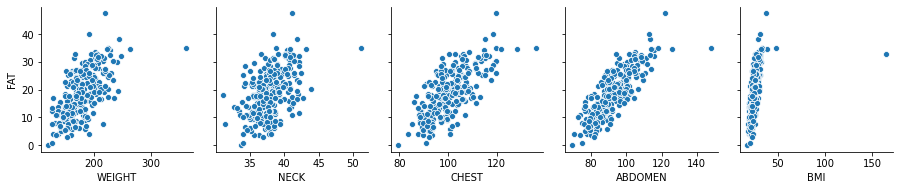

In [6]:
sns.pairplot(df_raw, y_vars="FAT", x_vars=["WEIGHT","NECK","CHEST","ABDOMEN", "BMI"])

: 이상치가 보여서 따로 빼서 본다.

In [7]:
df_raw[df_raw["BMI"]>100]

,FAT,AGE,WEIGHT,HEIGHT,NECK,CHEST,ABDOMEN,HIP,THIGH,KNEE,ANKLE,BICEPS,FOREARM,WRIST,BMI
78,32.9,44,205.0,29.5,36.6,106.0,104.3,115.5,70.6,42.5,23.7,33.6,28.7,17.4,164.3


In [8]:
df_raw = df_raw.drop([78])
df_raw

,FAT,AGE,WEIGHT,HEIGHT,NECK,CHEST,ABDOMEN,HIP,THIGH,KNEE,ANKLE,BICEPS,FOREARM,WRIST,BMI
0,35.2,46,363.15,72.25,51.2,136.2,148.1,147.7,87.3,49.1,29.6,45.0,29.0,21.4,48.5
1,11.8,27,168.00,71.25,38.1,93.0,79.1,94.5,57.3,36.2,24.5,29.0,30.0,18.8,23.1
2,22.2,69,177.75,68.50,38.7,102.0,95.0,98.3,55.0,38.3,21.8,30.8,25.7,18.8,26.4
3,10.6,57,147.75,65.75,35.2,99.6,86.4,90.1,53.0,35.0,21.3,31.7,27.3,16.9,23.8
4,47.5,51,219.00,64.00,41.2,119.8,122.1,112.8,62.5,36.9,23.6,34.7,29.1,18.4,37.3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
247,31.9,74,207.50,70.00,40.8,112.4,108.5,107.1,59.3,42.2,24.6,33.7,30.0,20.9,29.5
248,23.6,43,170.75,67.50,37.4,103.7,89.7,94.2,58.5,39.0,24.1,33.8,28.8,18.8,26.1
249,20.9,35,162.75,66.00,36.4,99.1,92.8,99.2,63.1,38.7,21.7,31.1,26.4,16.9,26.1
250,17.0,56,167.75,68.50,37.4,98.6,93.0,97.0,55.4,38.8,23.2,32.4,29.7,19.0,24.9


이상치가 아닐수도 있지만, 경향성을 파악하고 비교하는데에는 도움이 안 된다고 파악하여 뺀다.

In [9]:
df_raw.reset_index(drop=True, inplace=True)
df_raw

,FAT,AGE,WEIGHT,HEIGHT,NECK,CHEST,ABDOMEN,HIP,THIGH,KNEE,ANKLE,BICEPS,FOREARM,WRIST,BMI
0,35.2,46,363.15,72.25,51.2,136.2,148.1,147.7,87.3,49.1,29.6,45.0,29.0,21.4,48.5
1,11.8,27,168.00,71.25,38.1,93.0,79.1,94.5,57.3,36.2,24.5,29.0,30.0,18.8,23.1
2,22.2,69,177.75,68.50,38.7,102.0,95.0,98.3,55.0,38.3,21.8,30.8,25.7,18.8,26.4
3,10.6,57,147.75,65.75,35.2,99.6,86.4,90.1,53.0,35.0,21.3,31.7,27.3,16.9,23.8
4,47.5,51,219.00,64.00,41.2,119.8,122.1,112.8,62.5,36.9,23.6,34.7,29.1,18.4,37.3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
246,31.9,74,207.50,70.00,40.8,112.4,108.5,107.1,59.3,42.2,24.6,33.7,30.0,20.9,29.5
247,23.6,43,170.75,67.50,37.4,103.7,89.7,94.2,58.5,39.0,24.1,33.8,28.8,18.8,26.1
248,20.9,35,162.75,66.00,36.4,99.1,92.8,99.2,63.1,38.7,21.7,31.1,26.4,16.9,26.1
249,17.0,56,167.75,68.50,37.4,98.6,93.0,97.0,55.4,38.8,23.2,32.4,29.7,19.0,24.9


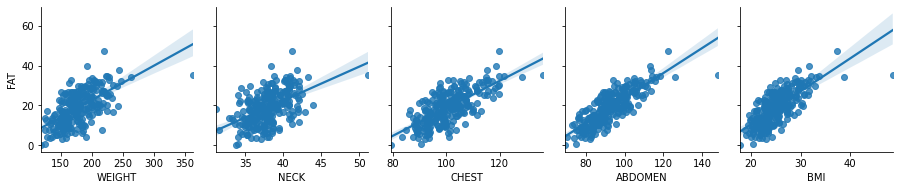

In [10]:
sns.pairplot(df_raw, y_vars="FAT", x_vars=["WEIGHT","NECK","CHEST","ABDOMEN", "BMI"], kind="reg")

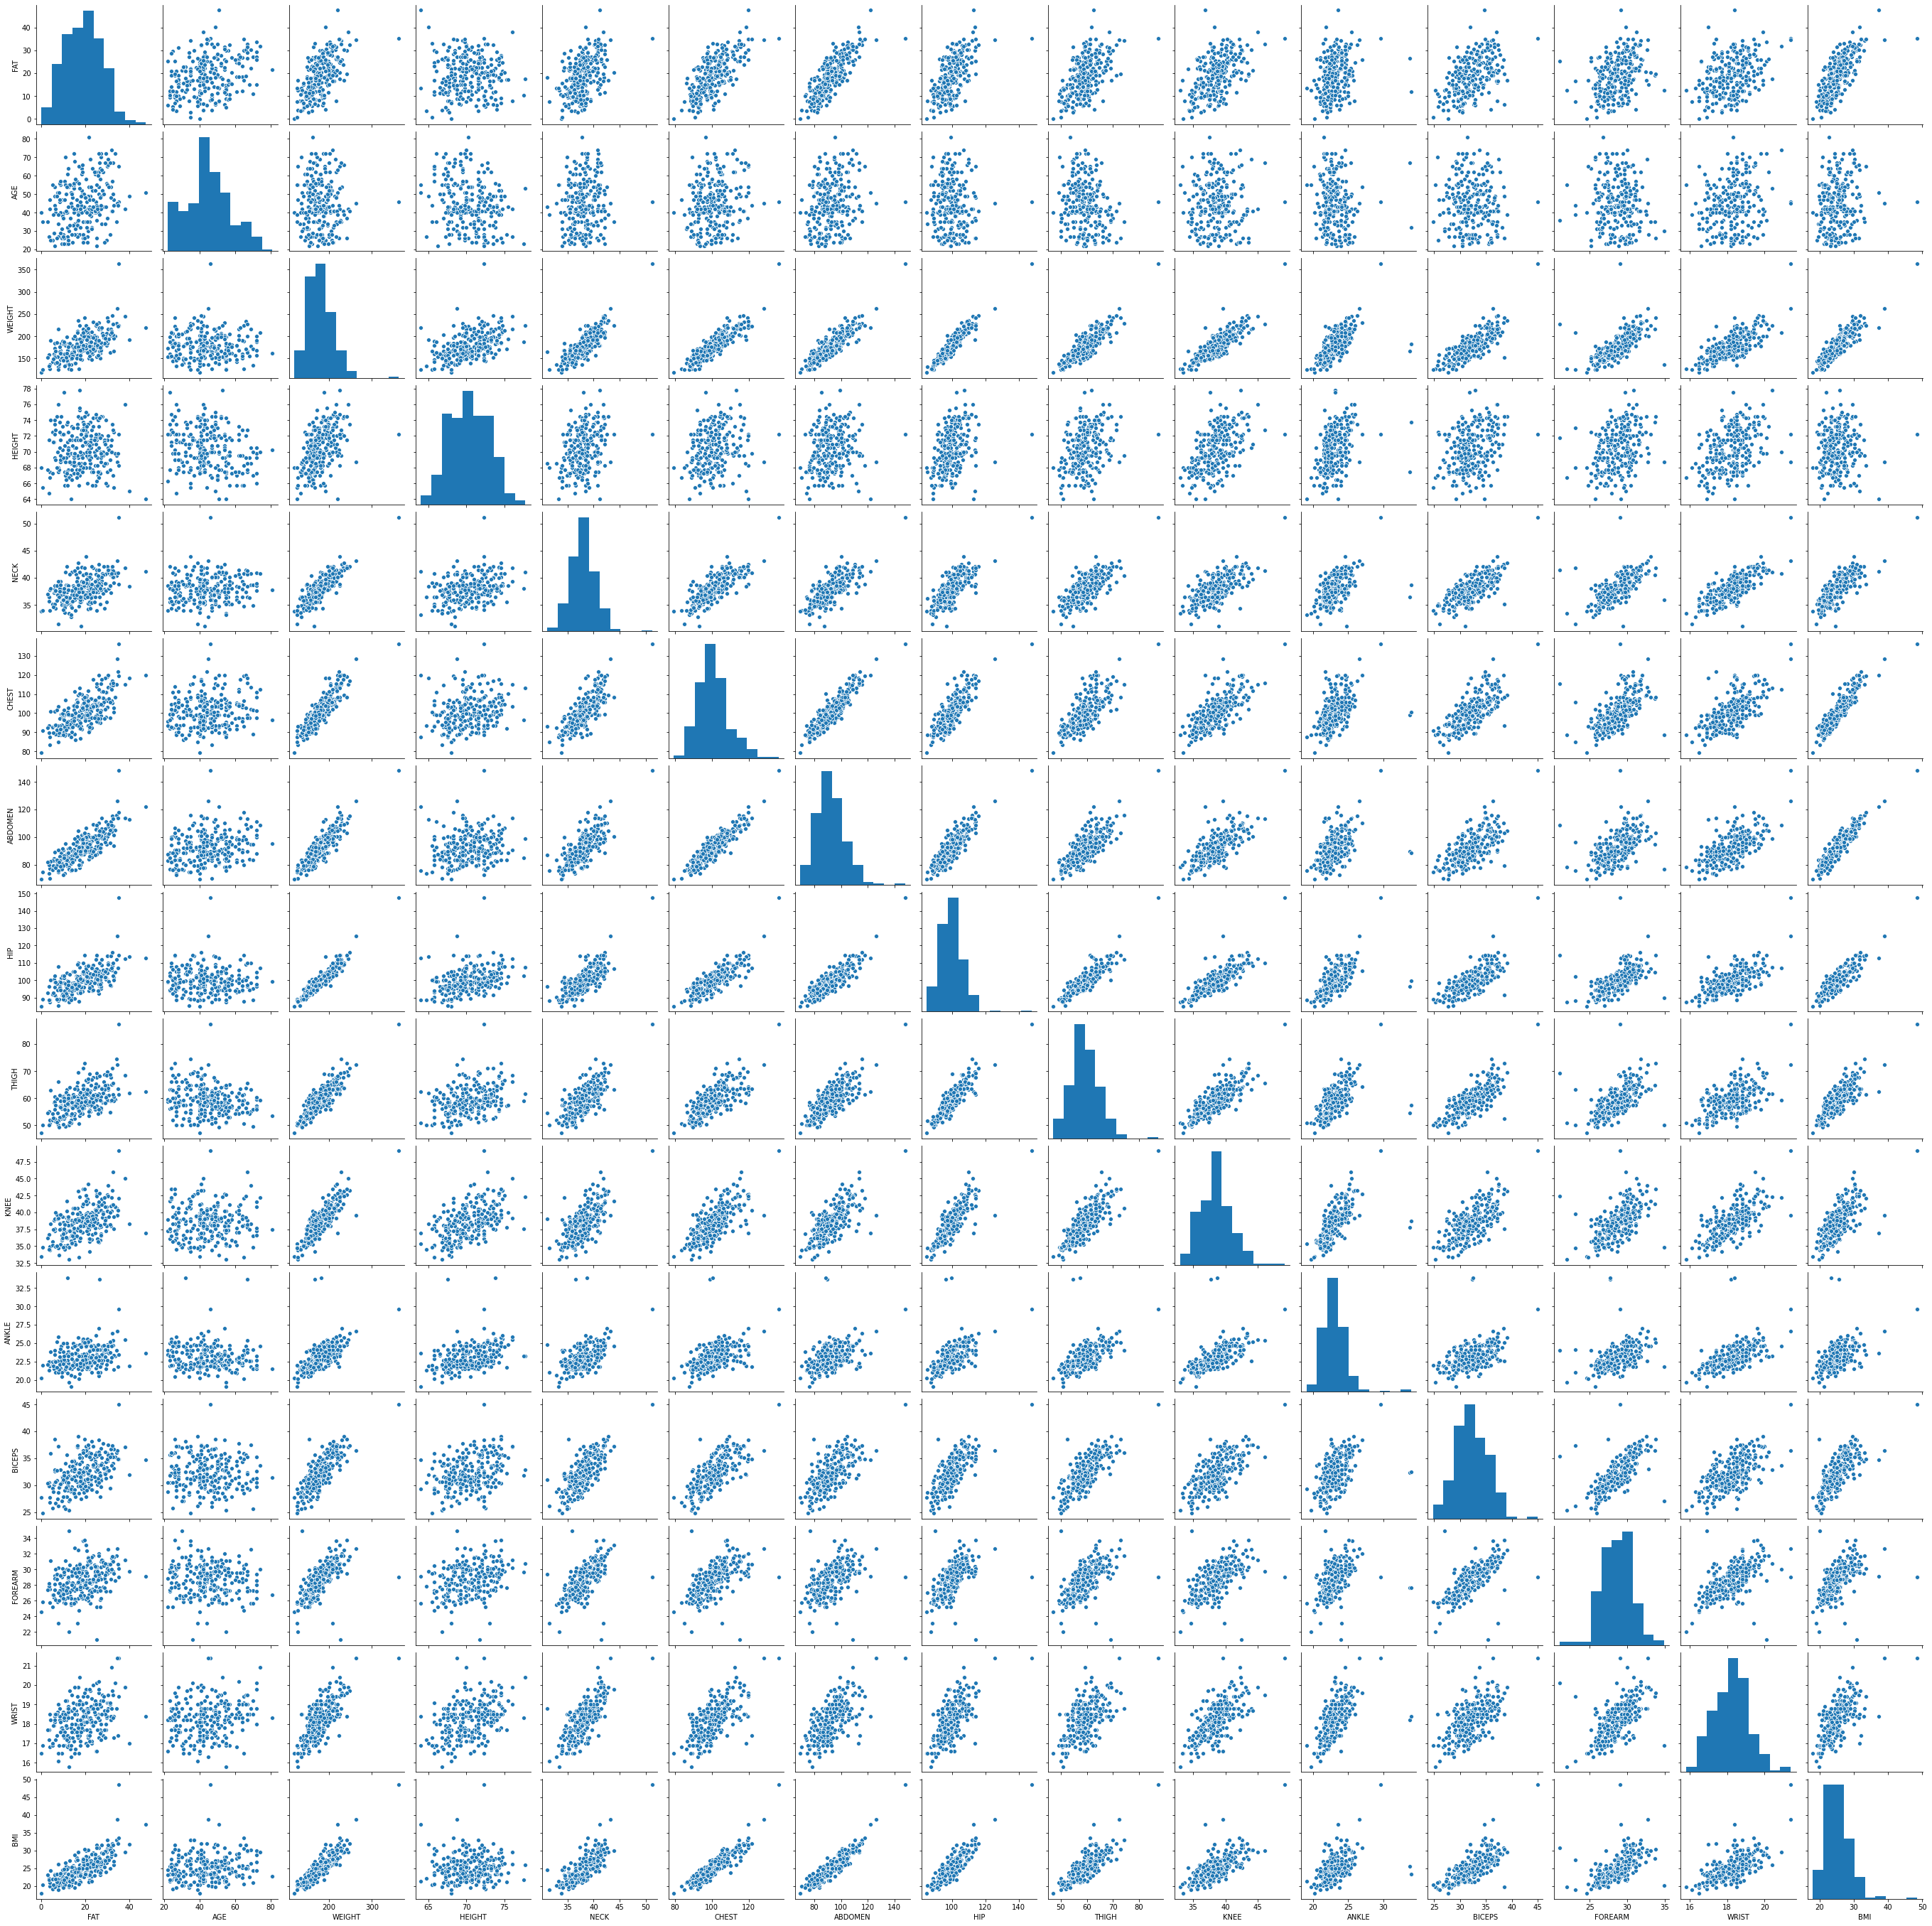

In [11]:
sns.pairplot(df_raw)

In [12]:
reg_model = smf.ols(formula = "FAT ~ AGE + WEIGHT + HEIGHT + NECK + CHEST + ABDOMEN + HIP + THIGH + KNEE + ANKLE + BICEPS + FOREARM + WRIST + BMI", data=df_raw)
reg_result = reg_model.fit()
print(reg_result.summary())

                            OLS Regression Results                            
Dep. Variable:                    FAT   R-squared:                       0.754
Model:                            OLS   Adj. R-squared:                  0.740
Method:                 Least Squares   F-statistic:                     51.73
Date:                Tue, 17 Nov 2020   Prob (F-statistic):           1.01e-63
Time:                        22:12:22   Log-Likelihood:                -711.92
No. Observations:                 251   AIC:                             1454.
Df Residuals:                     236   BIC:                             1507.
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   -152.0619     52.590     -2.891      0.0

In [13]:
df_raw_x = df_raw.drop(["FAT"],axis=1)
df_raw_x_const = add_constant(df_raw_x)
df_vif = pd.DataFrame()
df_vif["variable"] = df_raw_x_const.columns
df_vif["VIF"] = [variance_inflation_factor(df_raw_x_const.values, i) for i in range(df_raw_x_const.shape[1])
                ]                
df_vif.sort_values("VIF", inplace=True)
df_vif.round(3)

,variable,VIF
10,ANKLE,1.943
12,FOREARM,2.259
1,AGE,2.268
13,WRIST,3.390
11,BICEPS,3.673
4,NECK,4.449
9,KNEE,4.868
8,THIGH,7.863
5,CHEST,10.725
6,ABDOMEN,13.436


: BMI, WEIGHT는 다중공선성이 높기 때문에 활용하지 않는다.

In [14]:
reg_model = smf.ols(formula = "FAT ~ AGE + HEIGHT + NECK + CHEST + ABDOMEN + HIP + THIGH + KNEE + ANKLE + BICEPS + FOREARM + WRIST", data=df_raw)
reg_result = reg_model.fit()
print(reg_result.summary())

                            OLS Regression Results                            
Dep. Variable:                    FAT   R-squared:                       0.744
Model:                            OLS   Adj. R-squared:                  0.731
Method:                 Least Squares   F-statistic:                     57.61
Date:                Tue, 17 Nov 2020   Prob (F-statistic):           2.07e-63
Time:                        22:12:22   Log-Likelihood:                -717.09
No. Observations:                 251   AIC:                             1460.
Df Residuals:                     238   BIC:                             1506.
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     10.3921      8.737      1.189      0.2

In [15]:
df_raw_x = df_raw.drop(["FAT","WEIGHT", "BMI"],axis=1)
df_raw_x_const = add_constant(df_raw_x)
df_vif = pd.DataFrame()
df_vif["variable"] = df_raw_x_const.columns
df_vif["VIF"] = [variance_inflation_factor(df_raw_x_const.values, i) for i in range(df_raw_x_const.shape[1])
                ]                
df_vif.sort_values("VIF", inplace=True)
df_vif.round(3)

,variable,VIF
2,HEIGHT,1.755
9,ANKLE,1.843
1,AGE,2.182
11,FOREARM,2.194
12,WRIST,3.308
10,BICEPS,3.505
3,NECK,3.950
8,KNEE,4.728
7,THIGH,7.723
4,CHEST,7.889


In [16]:
df_raw_y = df_raw["FAT"]
model = LinearRegression()
rfe = RFE(estimator = model, n_features_to_select = 5).fit(df_raw_x, df_raw_y)
selected_cols = df_raw_x.columns[rfe.support_]
removed_cols = df_raw_x.columns[~rfe.support_]

print("Selected Variable: {}".format(selected_cols))
print("Removed Variable: {}".format(removed_cols))

Selected Variable: Index(['NECK', 'ABDOMEN', 'HIP', 'FOREARM', 'WRIST'], dtype='object')
Removed Variable: Index(['AGE', 'HEIGHT', 'CHEST', 'THIGH', 'KNEE', 'ANKLE', 'BICEPS'], dtype='object')


In [17]:
rfe_reg_model = smf.ols(formula = "FAT ~ NECK + ABDOMEN + HIP + FOREARM + WRIST", data=df_raw)
rfe_reg_result = rfe_reg_model.fit()
print(rfe_reg_result.summary())

                            OLS Regression Results                            
Dep. Variable:                    FAT   R-squared:                       0.730
Model:                            OLS   Adj. R-squared:                  0.724
Method:                 Least Squares   F-statistic:                     132.5
Date:                Tue, 17 Nov 2020   Prob (F-statistic):           1.45e-67
Time:                        22:12:22   Log-Likelihood:                -723.73
No. Observations:                 251   AIC:                             1459.
Df Residuals:                     245   BIC:                             1481.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      2.5851      6.224      0.415      0.6

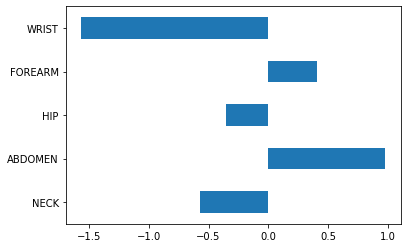

In [18]:
df_reg_coef = pd.DataFrame({"Coef":rfe_reg_result.params.values[1:]}, index = selected_cols)
df_reg_coef.plot.barh(y="Coef",legend = False)

                            OLS Regression Results                            
Dep. Variable:                    FAT   R-squared:                       0.730
Model:                            OLS   Adj. R-squared:                  0.724
Method:                 Least Squares   F-statistic:                     132.5
Date:                Tue, 17 Nov 2020   Prob (F-statistic):           1.45e-67
Time:                        22:12:22   Log-Likelihood:                -723.73
No. Observations:                 251   AIC:                             1459.
Df Residuals:                     245   BIC:                             1481.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     19.0960      0.276     69.106      0.0

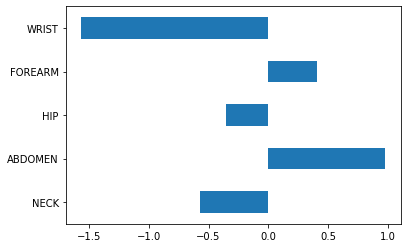

In [19]:
scaler = StandardScaler()

cols = df_raw_x.columns

np_scaled = scaler.fit_transform(df_raw_x)
df_scaled = pd.DataFrame(np_scaled, columns = cols)

df_scaled["FAT"]=df_raw["FAT"]
reg_model_scaled = smf.ols(formula = "FAT ~ NECK + ABDOMEN + HIP + FOREARM + WRIST", data=df_scaled)
reg_result_scaled = reg_model_scaled.fit()
print(reg_result_scaled.summary())

df_reg_coef = pd.DataFrame({"Coef":rfe_reg_result.params.values[1:]}, index = selected_cols)
df_reg_coef.plot.barh(y="Coef",legend = False)

# 의사결정너무_예측

In [20]:
import os

os.environ["PATH"] += os.pathsep + "~/Users/Juno/Library/Python/3.8/lib/python/site-packages/"

In [21]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib

from sklearn.tree import export_graphviz

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV

In [22]:
df_raw = pd.read_csv("~/Desktop/coding/postech/python/Postech_Academy/Practice/data/Concrete.csv", engine="python",encoding="EUC-KR")
df_raw.head()

,CEMENT,BLAST_FURNACE_SLAG,FLY_ASH,WATER,SUPERPLASTICIZER,COARSE_AGGREGATE,FINE_AGGREGATE,AGE,CONCRETE_COMPRESSIVE_STRENGTH
0,540.0,0.0,0.0,162.0,2.5,1040.0,676.0,28,79.99
1,540.0,0.0,0.0,162.0,2.5,1055.0,676.0,28,61.89
2,332.5,142.5,0.0,228.0,0.0,932.0,594.0,270,40.27
3,332.5,142.5,0.0,228.0,0.0,932.0,594.0,365,41.05
4,198.6,132.4,0.0,192.0,0.0,978.4,825.5,360,44.30


In [23]:
df_raw.head()

,CEMENT,BLAST_FURNACE_SLAG,FLY_ASH,WATER,SUPERPLASTICIZER,COARSE_AGGREGATE,FINE_AGGREGATE,AGE,CONCRETE_COMPRESSIVE_STRENGTH
0,540.0,0.0,0.0,162.0,2.5,1040.0,676.0,28,79.99
1,540.0,0.0,0.0,162.0,2.5,1055.0,676.0,28,61.89
2,332.5,142.5,0.0,228.0,0.0,932.0,594.0,270,40.27
3,332.5,142.5,0.0,228.0,0.0,932.0,594.0,365,41.05
4,198.6,132.4,0.0,192.0,0.0,978.4,825.5,360,44.30


In [24]:
df_raw.isnull().sum()

CEMENT                           0
BLAST_FURNACE_SLAG               0
FLY_ASH                          0
WATER                            0
SUPERPLASTICIZER                 0
COARSE_AGGREGATE                 0
FINE_AGGREGATE                   0
AGE                              0
CONCRETE_COMPRESSIVE_STRENGTH    0
dtype: int64

In [25]:
df_raw_y = df_raw["CONCRETE_COMPRESSIVE_STRENGTH"]
df_raw_x = df_raw.drop("CONCRETE_COMPRESSIVE_STRENGTH", axis=1, inplace=False)

In [26]:
df_train_x, df_test_x, df_train_y, df_test_y = train_test_split(df_raw_x, df_raw_y, test_size = 0.3, random_state= 1234)
print("train data X size : {}".format(df_train_x.shape))
print("train data Y size : {}".format(df_train_y.shape))
print("test data X size : {}".format(df_test_x.shape))
print("test data Y size : {}".format(df_test_y.shape))

train data X size : (721, 8)
train data Y size : (721,)
test data X size : (309, 8)
test data Y size : (309,)


In [27]:
df_train_x, df_valid_x, df_train_y, df_valid_y = train_test_split(df_train_x, df_train_y, test_size = 0.428, random_state= 1234)
print("train data X size : {}".format(df_train_x.shape))
print("train data Y size : {}".format(df_train_y.shape))
print("validation data X size : {}".format(df_valid_x.shape))
print("validation data Y size : {}".format(df_valid_y.shape))

train data X size : (412, 8)
train data Y size : (412,)
validation data X size : (309, 8)
validation data Y size : (309,)


In [28]:
tree_uncustomized = DecisionTreeRegressor(random_state=1234)
tree_uncustomized.fit(df_train_x, df_train_y)

print("Score on training set: {:.3f}".format(tree_uncustomized.score(df_train_x, df_train_y)))
print("Score on valid set: {:.3f}".format(tree_uncustomized.score(df_valid_x, df_valid_y)))

Score on training set: 1.000
Score on valid set: 0.685


In [29]:
# min_samples_leaf

train_score = []
valid_score = []

para_leaf = [n_leaf * 1 for n_leaf in range(1,20)]
for v_min_samples_leaf in para_leaf: # para_leaf : [1,2,3,...,19]
    tree = DecisionTreeRegressor(random_state=1234, min_samples_leaf=v_min_samples_leaf)
    tree.fit(df_train_x, df_train_y)
    train_score.append(tree.score(df_train_x, df_train_y))
    valid_score.append(tree.score(df_valid_x, df_valid_y))
    
df_score_leaf = pd.DataFrame()
df_score_leaf["MinSamplesLeaf"] = para_leaf
df_score_leaf["TrainScore"] = train_score
df_score_leaf["ValidScore"] = valid_score

In [30]:
df_score_leaf.round(3)

,MinSamplesLeaf,TrainScore,ValidScore
0,1,1.000,0.685
1,2,0.984,0.688
2,3,0.962,0.688
3,4,0.948,0.718
4,5,0.918,0.681
5,6,0.908,0.678
6,7,0.889,0.679
7,8,0.876,0.671
8,9,0.862,0.659
9,10,0.857,0.663


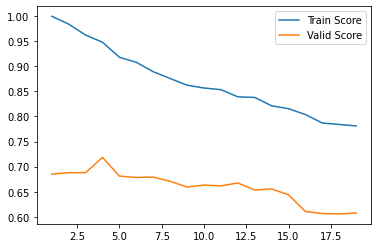

In [31]:
plt.plot(para_leaf, train_score, linestyle="-", label="Train Score")
plt.plot(para_leaf, valid_score, linestyle="-", label="Valid Score")
plt.legend()

# 4로 선정

In [32]:
# min_saples_split

train_score = []
valid_score = []

para_split = [n_split * 2 for n_split in range(1,20)]
for v_min_samples_split in para_split:
    tree = DecisionTreeRegressor(random_state=1234, min_samples_leaf=4, min_samples_split=v_min_samples_split)
    tree.fit(df_train_x, df_train_y)
    train_score.append(tree.score(df_train_x, df_train_y))
    valid_score.append(tree.score(df_valid_x, df_valid_y))
    
df_score_split = pd.DataFrame()
df_score_split["MinSamplesSplit"] = para_split
df_score_split["TrainScore"] = train_score
df_score_split["ValidScore"] = valid_score

In [33]:
df_score_split

,MinSamplesSplit,TrainScore,ValidScore
0,2,0.947943,0.718344
1,4,0.947943,0.718344
2,6,0.947943,0.718344
3,8,0.947943,0.718344
4,10,0.938725,0.711672
5,12,0.926316,0.700035
6,14,0.910425,0.702537
7,16,0.902446,0.692683
8,18,0.884122,0.680461
9,20,0.872563,0.659502


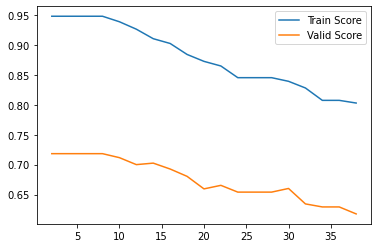

In [34]:
plt.plot(para_split, train_score, linestyle="-", label="Train Score")
plt.plot(para_split, valid_score, linestyle="-", label="Valid Score")
plt.legend()

# 10으로 선정

In [35]:
# max_depth 수정

train_score = []
valid_score = []

para_depth = [depth for depth in range(1,11)]

for v_max_depth in para_depth: # para_depth : [1,2,3,...,10]
    tree = DecisionTreeRegressor(random_state=1234, min_samples_leaf=4, min_samples_split=10, max_depth = v_max_depth)
    tree.fit(df_train_x, df_train_y)
    train_score.append(tree.score(df_train_x, df_train_y))
    valid_score.append(tree.score(df_valid_x, df_valid_y))
    
df_score_depth = pd.DataFrame()
df_score_depth["Depth"] = para_depth
df_score_depth["TrainScore"] = train_score
df_score_depth["ValidScore"] = valid_score

In [36]:
df_score_depth

,Depth,TrainScore,ValidScore
0,1,0.287852,0.190332
1,2,0.523977,0.399904
2,3,0.662121,0.482164
3,4,0.765511,0.585653
4,5,0.846583,0.623916
5,6,0.892752,0.656597
6,7,0.920033,0.703702
7,8,0.932759,0.708027
8,9,0.936890,0.707094
9,10,0.938520,0.700931


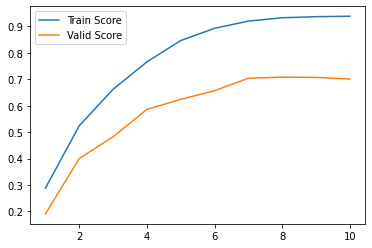

In [37]:
plt.plot(para_depth, train_score, linestyle="-", label="Train Score")
plt.plot(para_depth, valid_score, linestyle="-", label="Valid Score")
plt.legend()

# depth 6으로 선정

In [38]:
tree_final = DecisionTreeRegressor(random_state=1234, min_samples_leaf=4, min_samples_split=10, max_depth=6)
tree_final.fit(df_train_x, df_train_y)

print("Score on training set: {:.3f}".format(tree_final.score(df_train_x, df_train_y)))
print("Score on test set: {:.3f}".format(tree_final.score(df_test_x, df_test_y)))

Score on training set: 0.893
Score on test set: 0.740


: test 결과, 0.740가 나왔다.

In [39]:
v_feature_name = df_train_x.columns

df_importance = pd.DataFrame()
df_importance['Feature'] = v_feature_name
df_importance['Importance'] = tree_final.feature_importances_

df_importance.sort_values("Importance", ascending=False, inplace=True)
df_importance.round(3)

,Feature,Importance
7,AGE,0.351
0,CEMENT,0.350
3,WATER,0.168
1,BLAST_FURNACE_SLAG,0.063
5,COARSE_AGGREGATE,0.023
2,FLY_ASH,0.021
6,FINE_AGGREGATE,0.017
4,SUPERPLASTICIZER,0.006


Text(0, 0.5, 'Variable')

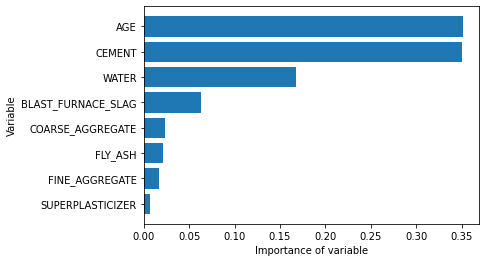

In [40]:
df_importance.sort_values("Importance", ascending=True, inplace=True)
coordinates = range(len(df_importance))
plt.barh(y=coordinates, width = df_importance["Importance"])
plt.yticks(coordinates, df_importance["Feature"])
plt.xlabel("Importance of variable")
plt.ylabel("Variable")

# 랜덤 포레스트_예측

In [55]:
from sklearn.ensemble import RandomForestRegressor

In [56]:
df_raw = pd.read_csv("~/Desktop/coding/postech/python/Postech_Academy/Practice/data/Concrete.csv", engine="python",encoding="EUC-KR")
df_raw.head()

,CEMENT,BLAST_FURNACE_SLAG,FLY_ASH,WATER,SUPERPLASTICIZER,COARSE_AGGREGATE,FINE_AGGREGATE,AGE,CONCRETE_COMPRESSIVE_STRENGTH
0,540.0,0.0,0.0,162.0,2.5,1040.0,676.0,28,79.99
1,540.0,0.0,0.0,162.0,2.5,1055.0,676.0,28,61.89
2,332.5,142.5,0.0,228.0,0.0,932.0,594.0,270,40.27
3,332.5,142.5,0.0,228.0,0.0,932.0,594.0,365,41.05
4,198.6,132.4,0.0,192.0,0.0,978.4,825.5,360,44.30


In [57]:
df_raw.head()

,CEMENT,BLAST_FURNACE_SLAG,FLY_ASH,WATER,SUPERPLASTICIZER,COARSE_AGGREGATE,FINE_AGGREGATE,AGE,CONCRETE_COMPRESSIVE_STRENGTH
0,540.0,0.0,0.0,162.0,2.5,1040.0,676.0,28,79.99
1,540.0,0.0,0.0,162.0,2.5,1055.0,676.0,28,61.89
2,332.5,142.5,0.0,228.0,0.0,932.0,594.0,270,40.27
3,332.5,142.5,0.0,228.0,0.0,932.0,594.0,365,41.05
4,198.6,132.4,0.0,192.0,0.0,978.4,825.5,360,44.30


In [58]:
df_raw.isnull().sum()

CEMENT                           0
BLAST_FURNACE_SLAG               0
FLY_ASH                          0
WATER                            0
SUPERPLASTICIZER                 0
COARSE_AGGREGATE                 0
FINE_AGGREGATE                   0
AGE                              0
CONCRETE_COMPRESSIVE_STRENGTH    0
dtype: int64

In [59]:
df_raw_y = df_raw["CONCRETE_COMPRESSIVE_STRENGTH"]
df_raw_x = df_raw.drop("CONCRETE_COMPRESSIVE_STRENGTH", axis=1, inplace=False)

In [60]:
df_train_x, df_test_x, df_train_y, df_test_y = train_test_split(df_raw_x, df_raw_y, test_size = 0.3, random_state= 1234)
print("train data X size : {}".format(df_train_x.shape))
print("train data Y size : {}".format(df_train_y.shape))
print("test data X size : {}".format(df_test_x.shape))
print("test data Y size : {}".format(df_test_y.shape))

train data X size : (721, 8)
train data Y size : (721,)
test data X size : (309, 8)
test data Y size : (309,)


In [61]:
df_train_x, df_valid_x, df_train_y, df_valid_y = train_test_split(df_train_x, df_train_y, test_size = 0.428, random_state= 1234)
print("train data X size : {}".format(df_train_x.shape))
print("train data Y size : {}".format(df_train_y.shape))
print("validation data X size : {}".format(df_valid_x.shape))
print("validation data Y size : {}".format(df_valid_y.shape))

train data X size : (412, 8)
train data Y size : (412,)
validation data X size : (309, 8)
validation data Y size : (309,)


In [62]:
rf_uncustomized = RandomForestRegressor(random_state=1234)
rf_uncustomized.fit(df_train_x, df_train_y)

print("Score on training set: {:.3f}".format(rf_uncustomized.score(df_train_x, df_train_y)))
print("Score on validation set: {:.3f}".format(rf_uncustomized.score(df_valid_x, df_valid_y)))

Score on training set: 0.982
Score on validation set: 0.821


In [63]:
train_score = []
valid_score = []

para_n_tree = [n_tree*10 for n_tree in range(1,11)]

for v_n_estimators in para_n_tree:
    rf = RandomForestRegressor(n_estimators=v_n_estimators, random_state=1234)
    rf.fit(df_train_x, df_train_y)
    train_score.append(rf.score(df_train_x, df_train_y))
    valid_score.append(rf.score(df_valid_x, df_valid_y))
    
df_score_n = pd.DataFrame()
df_score_n["n_estimators"] = para_n_tree
df_score_n["TrainScore"] = train_score
df_score_n["ValidScore"] = valid_score

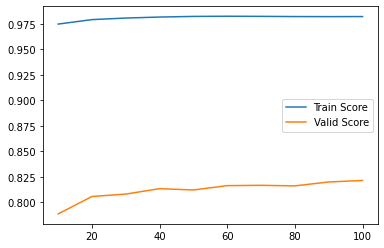

In [64]:
plt.plot(para_n_tree, train_score, linestyle="-", label="Train Score")
plt.plot(para_n_tree, valid_score, linestyle="-", label="Valid Score")
plt.legend()

In [66]:
# n_estimators = 100 으로 결정
train_score = []
valid_score = []

para_leaf = [n_leaf*1 for n_leaf in range(1,11)]

for v_min_leaf in para_leaf:
    rf = RandomForestRegressor(n_estimators=100, min_samples_leaf=v_min_leaf, random_state=1234)
    rf.fit(df_train_x, df_train_y)
    train_score.append(rf.score(df_train_x, df_train_y))
    valid_score.append(rf.score(df_valid_x, df_valid_y))
    
df_score_leaf = pd.DataFrame()
df_score_leaf["n_leaf"] = para_leaf
df_score_leaf["TrainScore"] = train_score
df_score_leaf["ValidScore"] = valid_score

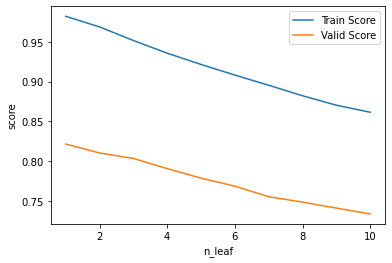

In [67]:
plt.plot(para_leaf, train_score, linestyle="-", label="Train Score")
plt.plot(para_leaf, valid_score, linestyle="-", label="Valid Score")
plt.ylabel("score")
plt.xlabel("n_leaf")
plt.legend()

In [71]:
# min_samples_leaf = 4로 설정
train_score = []
valid_score = []

para_split = [n_split*2 for n_split in range(2,21)]

for v_min_samples_split in para_split:
    rf = RandomForestRegressor(n_estimators=100, min_samples_leaf=4,min_samples_split=v_min_samples_split, random_state=1234)
    rf.fit(df_train_x, df_train_y)
    train_score.append(rf.score(df_train_x, df_train_y))
    valid_score.append(rf.score(df_valid_x, df_valid_y))
    
df_score_split = pd.DataFrame()
df_score_split["MinSamplesSplit"] = para_split
df_score_split["TrainScore"] = train_score
df_score_split["ValidScore"] = valid_score

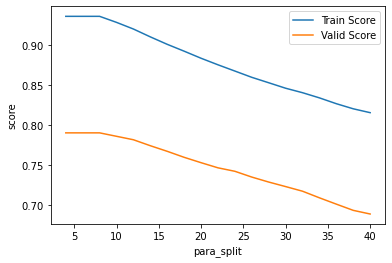

In [72]:
plt.plot(para_split, train_score, linestyle="-", label="Train Score")
plt.plot(para_split, valid_score, linestyle="-", label="Valid Score")
plt.ylabel("score")
plt.xlabel("para_split")
plt.legend()

In [73]:
# para_split = 8 로 설정
train_score = []
valid_score = []

para_depth = [depth for depth in range(1,11)]

for v_max_depth in para_depth:
    rf = RandomForestRegressor(n_estimators=100, min_samples_leaf=4,min_samples_split=8, max_depth=v_max_depth, random_state=1234)
    rf.fit(df_train_x, df_train_y)
    train_score.append(rf.score(df_train_x, df_train_y))
    valid_score.append(rf.score(df_valid_x, df_valid_y))
    
df_score_depth = pd.DataFrame()
df_score_depth["Depth"] = para_depth
df_score_depth["TrainScore"] = train_score
df_score_depth["ValidScore"] = valid_score

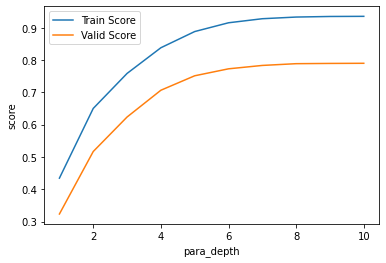

In [74]:
plt.plot(para_depth, train_score, linestyle="-", label="Train Score")
plt.plot(para_depth, valid_score, linestyle="-", label="Valid Score")
plt.ylabel("score")
plt.xlabel("para_depth")
plt.legend()

In [81]:
# para_depth = 10 으로 설정
rf_final = RandomForestRegressor(random_state=1234, n_estimators=100, min_samples_leaf = 4, min_samples_split = 8, max_depth=10)
rf_final.fit(df_train_x, df_train_y)

print("Score on training set: {:.3f}".format(rf_final.score(df_train_x, df_train_y)))
print("Score on test set: {:.3f}".format(rf_final.score(df_test_x, df_test_y)))

Score on training set: 0.936
Score on test set: 0.833


In [82]:
df_importance = pd.DataFrame()
df_importance['Feature'] = v_feature_name
df_importance['Importance'] = rf_final.feature_importances_

df_importance.sort_values("Importance", ascending=False, inplace=True)
df_importance.round(3)

,Feature,Importance
7,AGE,0.321
0,CEMENT,0.296
3,WATER,0.233
1,BLAST_FURNACE_SLAG,0.055
6,FINE_AGGREGATE,0.035
4,SUPERPLASTICIZER,0.022
5,COARSE_AGGREGATE,0.021
2,FLY_ASH,0.018


Text(0, 0.5, 'Variable')

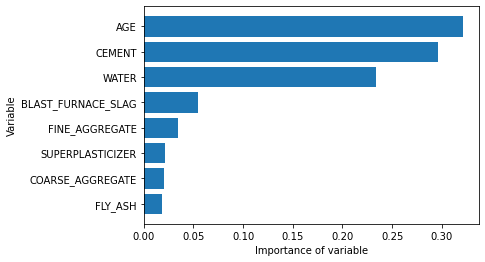

In [83]:
df_importance.sort_values("Importance", ascending=True, inplace=True)
coordinates = range(len(df_importance))
plt.barh(y=coordinates, width = df_importance["Importance"])
plt.yticks(coordinates, df_importance["Feature"])
plt.xlabel("Importance of variable")
plt.ylabel("Variable")